# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_056  P41217;P41217-2;P41217-3;U3KQG5   17.306
Sample_122  P10643                            20.472
Sample_111  P55291                            15.997
Sample_129  P55290;P55290-4                   20.148
Sample_177  Q15293                            14.724
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups          
Sample_005  P42262;P42262-2;P42262-3   15.812
Sample_047  A0A0C4DGY8;D6RA00;Q9UHY7   13.562
Sample_169  Q9BT88                     14.892
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.508
            A0A075B6Q5                 12.381
            A0A075B6R2                 12.452
            A0A075B6S5                 14.006
            A0A087WSY4                 13.351
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.983
            Q9UI40;Q9UI40-2            12.846
            Q9UIW2                     12.575
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.414
            Q9UP79                     11.758
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.903,15.050,16.842,19.863,15.542,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.650,19.067,...,15.528,15.576,13.797,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.821,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.353,17.705,17.039,15.992,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.577,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.158,15.345,17.084,18.708,14.249,19.433,12.046,11.163
Sample_207,15.739,16.877,15.469,16.898,14.891,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.508,...,16.012,15.178,12.953,15.050,16.842,19.863,14.527,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.394,19.067,16.188,...,15.528,15.576,12.211,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.587,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,14.046,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.899,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.834,15.345,17.084,18.708,14.249,19.433,12.761,12.858
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.20it/s]

100%|██████████| 3/3 [00:00<00:00,  2.96it/s]

100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.28it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.87it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.70it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.83it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.02it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.70it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.57it/s]

100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.63it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.97it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.84it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.71it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.58it/s]

100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.92it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.87it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.59it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.61it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.64it/s]

100%|██████████| 8/8 [00:02<00:00,  2.56it/s]

100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.34it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.08it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.80it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.59it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.38it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.40it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.45it/s]

100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.28it/s]

 30%|███       | 3/10 [00:01<00:02,  2.50it/s]

 40%|████      | 4/10 [00:01<00:02,  2.43it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.33it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.41it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.43it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.40it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.44it/s]

100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:03,  2.90it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.54it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.41it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.32it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.34it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.39it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.54it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.42it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.52it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.41it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.99it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.73it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.58it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.57it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.46it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.44it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.43it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.45it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.42it/s]

100%|██████████| 12/12 [00:04<00:00,  2.36it/s]

100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.24it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.44it/s]

 31%|███       | 4/13 [00:01<00:03,  2.56it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.64it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.70it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.64it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.69it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.63it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.58it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.63it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.47it/s]

100%|██████████| 13/13 [00:04<00:00,  2.51it/s]

100%|██████████| 13/13 [00:05<00:00,  2.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.29it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.30it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.09it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.10it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.21it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.33it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.31it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.22it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.20it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.40it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.42it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.48it/s]

100%|██████████| 14/14 [00:05<00:00,  2.47it/s]

100%|██████████| 14/14 [00:05<00:00,  2.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.40it/s]

 20%|██        | 3/15 [00:01<00:04,  2.45it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.35it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.34it/s]

 40%|████      | 6/15 [00:02<00:03,  2.26it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.33it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.32it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.50it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.45it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.44it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.40it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.41it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.37it/s]

100%|██████████| 15/15 [00:06<00:00,  2.42it/s]

100%|██████████| 15/15 [00:06<00:00,  2.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.048 0.003          0.651 0.422       0.091   
2             0.004 0.000      0.048 0.006          0.700 0.118       0.516   
3             0.004 0.000      0.048 0.005          0.711 0.114       0.623   
4             0.004 0.003      0.049 0.006          0.719 0.083       0.722   
5             0.004 0.000      0.048 0.004          0.772 0.093       0.726   
6             0.004 0.000      0.049 0.007          0.779 0.082       0.751   
7             0.004 0.000      0.048 0.004          0.817 0.082       0.838   
8             0.004 0.002      0.048 0.004          0.820 0.086       0.834   
9             0.004 0.002      0.044 0.010          0.815 0.090       0.832   
10            0.004 0.001      0.051 0.013          0.808 0.093       0.807   
11            0.004 0.000      0.047 0.005          0.810 0.094       0.812   
12            0.005 0.002      0.051 0.011          0.817 0.080       0.812   
13            0.004 0.001      0.052 0.015          0.807 0.088       0.813   
14            0.005 0.003      0.054 0.019          0.803 0.089       0.807   
15            0.005 0.004      0.051 0.013          0.803 0.082       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.153 0.128                  0.538 0.039        0.854   
2          0.111   0.584 0.086                  0.672 0.059        0.722   
3          0.130   0.653 0.088                  0.713 0.069        0.788   
4          0.110   0.716 0.080                  0.756 0.066        0.833   
5          0.103   0.743 0.077                  0.782 0.062        0.850   
6          0.109   0.759 0.072                  0.796 0.059        0.849   
7          0.077   0.823 0.054                  0.848 0.046        0.902   
8          0.080   0.822 0.055                  0.847 0.046        0.900   
9          0.080   0.819 0.057                  0.844 0.049        0.900   
10         0.094   0.803 0.068                  0.831 0.057        0.899   
11         0.098   0.806 0.071                  0.834 0.060        0.901   
12         0.092   0.811 0.067                  0.838 0.057        0.905   
13         0.090   0.806 0.069                  0.833 0.060        0.904   
14         0.096   0.802 0.075                  0.830 0.064        0.903   
15         0.091   0.800 0.065                  0.829 0.056        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.086        210.000 0.000  
2          0.082                  0.665 0.101        210.000 0.000  
3          0.077                  0.721 0.097        210.000 0.000  
4          0.064                  0.777 0.077        210.000 0.000  
5          0.062                  0.811 0.081        210.000 0.000  
6          0.056                  0.812 0.076        210.000 0.000  
7          0.048                  0.881 0.061        210.000 0.000  
8          0.049                  0.880 0.062        210.000 0.000  
9          0.050                  0.877 0.064        210.000 0.000  
10         0.051                  0.877 0.061        210.000 0.000  
11         0.050                  0.883 0.058        210.000 0.000  
12         0.051                  0.895 0.053        210.000 0.000  
13         0.052                  0.895 0.052        210.000 0.000  
14         0.052                  0.894 0.051        210.000 0.000  
15         0.053                  0.891 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 464.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.77it/s]

100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.99it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.17it/s]

100%|██████████| 4/4 [00:01<00:00,  1.90it/s]

100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.55it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.90it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.69it/s]

100%|██████████| 5/5 [00:02<00:00,  1.61it/s]

100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.96it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.61it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.01it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.73it/s]

100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.32it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.52it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  1.98it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.65it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.51it/s]

100%|██████████| 7/7 [00:03<00:00,  1.56it/s]

100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.82it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.49it/s]

 50%|█████     | 4/8 [00:01<00:02,  1.85it/s]

 62%|██████▎   | 5/8 [00:02<00:02,  1.49it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.33it/s]

 88%|████████▊ | 7/8 [00:04<00:00,  1.23it/s]

100%|██████████| 8/8 [00:05<00:00,  1.21it/s]

100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.20it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.26it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.45it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.88it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.67it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.58it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.57it/s]

100%|██████████| 9/9 [00:04<00:00,  1.66it/s]

100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.96it/s]

 30%|███       | 3/10 [00:00<00:01,  3.85it/s]

 40%|████      | 4/10 [00:01<00:02,  2.71it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.40it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.10it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.76it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.63it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.51it/s]

100%|██████████| 10/10 [00:05<00:00,  1.40it/s]

100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.17it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.14it/s]

 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

100%|██████████| 11/11 [00:06<00:00,  1.62it/s]

100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.64it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.75it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.26it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.06it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.06it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.08it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.91it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.76it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.60it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.45it/s]

100%|██████████| 12/12 [00:06<00:00,  1.45it/s]

100%|██████████| 12/12 [00:06<00:00,  1.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.44it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.80it/s]

 31%|███       | 4/13 [00:01<00:03,  2.62it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.97it/s]

 46%|████▌     | 6/13 [00:02<00:04,  1.74it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.65it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.70it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.81it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.65it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.57it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.65it/s]

100%|██████████| 13/13 [00:07<00:00,  1.61it/s]

100%|██████████| 13/13 [00:07<00:00,  1.83it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.98it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.68it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.06it/s]

 36%|███▌      | 5/14 [00:02<00:05,  1.79it/s]

 43%|████▎     | 6/14 [00:03<00:04,  1.65it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.81it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.93it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.06it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.95it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.79it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.69it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.74it/s]

100%|██████████| 14/14 [00:07<00:00,  1.73it/s]

100%|██████████| 14/14 [00:07<00:00,  1.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.19it/s]

 20%|██        | 3/15 [00:00<00:04,  2.90it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.38it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.10it/s]

 40%|████      | 6/15 [00:02<00:04,  1.90it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.97it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.12it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.09it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.76it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.57it/s]

 80%|████████  | 12/15 [00:06<00:02,  1.45it/s]

 87%|████████▋ | 13/15 [00:07<00:01,  1.44it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.53it/s]

100%|██████████| 15/15 [00:08<00:00,  1.64it/s]

100%|██████████| 15/15 [00:08<00:00,  1.83it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.063 0.032          0.000 0.000       0.000   
2             0.005 0.004      0.059 0.025          0.684 0.109       0.581   
3             0.004 0.002      0.050 0.016          0.659 0.098       0.584   
4             0.007 0.008      0.062 0.026          0.659 0.099       0.580   
5             0.005 0.003      0.057 0.020          0.725 0.104       0.643   
6             0.005 0.004      0.059 0.021          0.814 0.084       0.799   
7             0.005 0.004      0.057 0.023          0.805 0.087       0.812   
8             0.005 0.004      0.068 0.032          0.799 0.090       0.802   
9             0.007 0.006      0.074 0.036          0.797 0.085       0.801   
10            0.006 0.005      0.072 0.033          0.796 0.086       0.796   
11            0.007 0.008      0.080 0.036          0.800 0.083       0.783   
12            0.007 0.007      0.069 0.032          0.790 0.086       0.784   
13            0.006 0.004      0.071 0.035          0.790 0.081       0.785   
14            0.008 0.008      0.083 0.038          0.788 0.091       0.787   
15            0.007 0.006      0.072 0.034          0.804 0.089       0.782   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.008        0.852   
2          0.103   0.623 0.086                  0.690 0.064        0.781   
3          0.113   0.614 0.090                  0.681 0.067        0.781   
4          0.112   0.611 0.091                  0.679 0.066        0.776   
5          0.119   0.675 0.095                  0.731 0.071        0.792   
6          0.102   0.801 0.068                  0.831 0.057        0.901   
7          0.108   0.802 0.067                  0.831 0.057        0.902   
8          0.105   0.794 0.067                  0.824 0.058        0.899   
9          0.104   0.793 0.064                  0.823 0.054        0.898   
10         0.112   0.790 0.072                  0.821 0.061        0.899   
11         0.106   0.786 0.068                  0.818 0.057        0.906   
12         0.105   0.782 0.068                  0.814 0.057        0.904   
13         0.107   0.782 0.065                  0.814 0.054        0.904   
14         0.109   0.781 0.068                  0.813 0.057        0.905   
15         0.111   0.786 0.069                  0.818 0.057        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.089        210.000 0.000  
2          0.066                  0.726 0.097        210.000 0.000  
3          0.066                  0.719 0.097        210.000 0.000  
4          0.067                  0.714 0.098        210.000 0.000  
5          0.069                  0.755 0.098        210.000 0.000  
6          0.050                  0.875 0.062        210.000 0.000  
7          0.049                  0.876 0.061        210.000 0.000  
8          0.049                  0.875 0.060        210.000 0.000  
9          0.050                  0.873 0.060        210.000 0.000  
10         0.048                  0.876 0.056        210.000 0.000  
11         0.048                  0.883 0.056        210.000 0.000  
12         0.048                  0.880 0.057        210.000 0.000  
13         0.049                  0.881 0.056        210.000 0.000  
14         0.048                  0.883 0.057        210.000 0.000  
15         0.045                  0.897 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 825.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.43it/s]

100%|██████████| 3/3 [00:00<00:00, 15.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.87it/s]

100%|██████████| 4/4 [00:00<00:00, 10.97it/s]

100%|██████████| 4/4 [00:00<00:00, 11.47it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.29it/s]

100%|██████████| 5/5 [00:00<00:00, 13.89it/s]

100%|██████████| 5/5 [00:00<00:00, 13.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.59it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.92it/s]

100%|██████████| 6/6 [00:00<00:00, 13.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.37it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.89it/s]

100%|██████████| 7/7 [00:00<00:00, 10.33it/s]

100%|██████████| 7/7 [00:00<00:00, 11.06it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.14it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 13.96it/s]

100%|██████████| 8/8 [00:00<00:00, 13.86it/s]

100%|██████████| 8/8 [00:00<00:00, 14.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.43it/s]

 44%|████▍     | 4/9 [00:00<00:00, 11.89it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.37it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  9.43it/s]

100%|██████████| 9/9 [00:00<00:00,  9.99it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.05it/s]

 40%|████      | 4/10 [00:00<00:00, 11.85it/s]

 60%|██████    | 6/10 [00:00<00:00, 11.23it/s]

 80%|████████  | 8/10 [00:00<00:00, 11.15it/s]

100%|██████████| 10/10 [00:00<00:00, 12.03it/s]

100%|██████████| 10/10 [00:00<00:00, 11.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.39it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 11.33it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.19it/s]

 91%|█████████ | 10/11 [00:00<00:00, 11.45it/s]

100%|██████████| 11/11 [00:00<00:00, 11.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 15.09it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.04it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.61it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.33it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.99it/s]

100%|██████████| 12/12 [00:01<00:00, 11.32it/s]

100%|██████████| 12/12 [00:01<00:00, 11.14it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.09it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.94it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.44it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.82it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.61it/s]

100%|██████████| 13/13 [00:00<00:00, 13.09it/s]

100%|██████████| 13/13 [00:00<00:00, 13.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.98it/s]

 29%|██▊       | 4/14 [00:00<00:01,  9.97it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.97it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.21it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.98it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.90it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.66it/s]

100%|██████████| 14/14 [00:01<00:00,  9.28it/s]

100%|██████████| 14/14 [00:01<00:00,  9.65it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.73it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.89it/s]

 40%|████      | 6/15 [00:00<00:00,  9.43it/s]

 47%|████▋     | 7/15 [00:00<00:00,  9.06it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.33it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.14it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.21it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.73it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.09it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.65it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.14it/s]

100%|██████████| 15/15 [00:01<00:00,  8.00it/s]

100%|██████████| 15/15 [00:01<00:00,  8.18it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.067 0.030          0.000 0.000       0.000   
2             0.005 0.003      0.059 0.021          0.040 0.198       0.002   
3             0.004 0.000      0.055 0.017          0.498 0.399       0.062   
4             0.005 0.003      0.061 0.019          0.564 0.129       0.278   
5             0.004 0.001      0.052 0.014          0.628 0.104       0.488   
6             0.007 0.009      0.071 0.029          0.633 0.108       0.497   
7             0.005 0.003      0.056 0.019          0.621 0.108       0.491   
8             0.007 0.006      0.077 0.028          0.641 0.089       0.559   
9             0.004 0.002      0.057 0.017          0.612 0.087       0.530   
10            0.006 0.004      0.061 0.019          0.722 0.088       0.653   
11            0.005 0.003      0.063 0.021          0.724 0.083       0.685   
12            0.006 0.004      0.070 0.028          0.721 0.089       0.678   
13            0.006 0.005      0.057 0.019          0.721 0.088       0.672   
14            0.005 0.003      0.053 0.014          0.712 0.087       0.668   
15            0.005 0.002      0.058 0.019          0.712 0.088       0.669   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.731   
2          0.011   0.004 0.021                  0.499 0.009        0.560   
3          0.060   0.104 0.093                  0.516 0.025        0.516   
4          0.093   0.365 0.098                  0.559 0.052        0.613   
5          0.104   0.543 0.087                  0.636 0.063        0.746   
6          0.108   0.550 0.089                  0.641 0.064        0.739   
7          0.107   0.541 0.087                  0.633 0.063        0.735   
8          0.117   0.590 0.083                  0.663 0.063        0.742   
9          0.115   0.561 0.085                  0.641 0.061        0.735   
10         0.127   0.677 0.083                  0.732 0.063        0.796   
11         0.120   0.698 0.084                  0.746 0.066        0.807   
12         0.116   0.692 0.084                  0.741 0.066        0.806   
13         0.109   0.690 0.081                  0.739 0.063        0.802   
14         0.115   0.683 0.083                  0.734 0.065        0.798   
15         0.116   0.683 0.084                  0.733 0.065        0.795   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.073                  0.683 0.089        210.000 0.000  
2          0.135                  0.525 0.127        210.000 0.000  
3          0.081                  0.510 0.073        210.000 0.000  
4          0.067                  0.567 0.075        210.000 0.000  
5          0.071                  0.687 0.082        210.000 0.000  
6          0.069                  0.680 0.082        210.000 0.000  
7          0.070                  0.675 0.081        210.000 0.000  
8          0.073                  0.683 0.084        210.000 0.000  
9          0.069                  0.675 0.081        210.000 0.000  
10         0.062                  0.733 0.086        210.000 0.000  
11         0.059                  0.755 0.073        210.000 0.000  
12         0.060                  0.753 0.073        210.000 0.000  
13         0.060                  0.750 0.073        210.000 0.000  
14         0.063                  0.744 0.076        210.000 0.000  
15         0.063                  0.744 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,14,8
score_time,14,14,8
test_precision,8,6,11
test_recall,7,7,11
test_f1,7,7,11
test_balanced_accuracy,7,7,11
test_roc_auc,12,15,11
test_average_precision,13,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.50it/s]

 20%|██        | 3/15 [00:01<00:04,  2.51it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.43it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.34it/s]

 40%|████      | 6/15 [00:02<00:03,  2.30it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.39it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.44it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.31it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.18it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.99it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.76it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.67it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.66it/s]

100%|██████████| 15/15 [00:07<00:00,  1.75it/s]

100%|██████████| 15/15 [00:07<00:00,  2.04it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 16.75it/s]

 36%|███▋      | 4/11 [00:00<00:00,  9.78it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.04it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  8.96it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.37it/s]

100%|██████████| 11/11 [00:01<00:00,  9.73it/s]

100%|██████████| 11/11 [00:01<00:00,  9.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.55it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.16it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.61it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.31it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.18it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.14it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.10it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.30it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.06it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.98it/s]

100%|██████████| 12/12 [00:05<00:00,  1.98it/s]

100%|██████████| 12/12 [00:05<00:00,  2.23it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


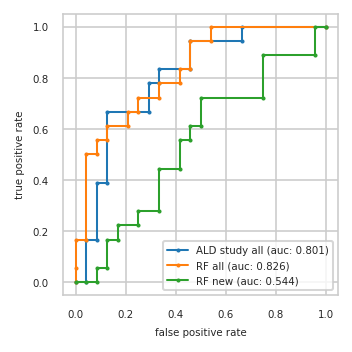

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.042 0.000
2          0.042 0.167  0.000 0.167  0.083 0.000
3          0.083 0.167  0.042 0.167  0.083 0.056
4          0.083 0.389  0.042 0.500  0.125 0.056
5          0.125 0.389  0.083 0.500  0.125 0.167
6          0.125 0.667  0.083 0.556  0.167 0.167
7          0.292 0.667  0.125 0.556  0.167 0.222
8          0.292 0.778  0.125 0.611  0.250 0.222
9          0.333 0.778  0.208 0.611  0.250 0.278
10         0.333 0.833  0.208 0.667  0.333 0.278
11         0.458 0.833  0.250 0.667  0.333 0.444
12         0.458 0.944  0.250 0.722  0.417 0.444
13         0.667 0.944  0.333 0.722  0.417 0.556
14         0.667 1.000  0.333 0.778  0.458 0.556
15         1.000 1.000  0.417 0.778  0.458 0.611
16           NaN   NaN  0.417 0.833  0.500 0.611
17           NaN   NaN  0.458 0.833  0.500 0.722
18           NaN   NaN  0.458 0.944  0.750 0.722
19           NaN   NaN  0.542 0.944  0.750 0.889
20           NaN   NaN  0.542 1.000  0.958 0.889
21           NaN   NaN  1.000 1.000  0.958 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q9NRN5,P60709;P63261,G3V295;G3V3I1;G3V5Z7;P60900
2,P09486,C9JIZ6;P07602;P07602-2;P07602-3,Q2UY09
3,K7ERG9;P00746,F8WE04;P04792,P10745
4,P14174,P10636-2;P10636-6,P31150
5,P10636-2;P10636-6,P04075,P31321
6,P61981,P14174,Q9NUQ9
7,P18428,P61981,Q96GD0
8,Q9Y2T3;Q9Y2T3-3,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


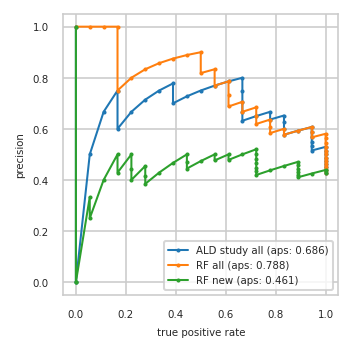

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.410 0.889
4          0.474 1.000     0.474 1.000     0.421 0.889
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.438 0.778
11         0.548 0.944     0.581 1.000     0.419 0.722
12         0.567 0.944     0.567 0.944     0.433 0.722
13         0.586 0.944     0.586 0.944     0.448 0.722
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.577 0.833     0.577 0.833     0.500 0.722
17         0.600 0.833     0.600 0.833     0.520 0.722
18         0.625 0.833     0.583 0.778     0.500 0.667
19         0.652 0.833     0.609 0.778     0.478 0.611
20         0.636 0.778     0.636 0.778     0.500 0.611
21         0.667 0.778     0.619 0.722     0.476 0.556
22         0.650 0.722     0.650 0.722     0.500 0.556
23         0.632 0.667     0.684 0.722     0.474 0.500
24         0.667 0.667     0.667 0.667     0.444 0.444
25         0.706 0.667     0.706 0.667     0.471 0.444
26         0.750 0.667     0.688 0.611     0.500 0.444
27         0.800 0.667     0.733 0.611     0.467 0.389
28         0.786 0.611     0.786 0.611     0.429 0.333
29         0.769 0.556     0.769 0.556     0.385 0.278
30         0.750 0.500     0.833 0.556     0.417 0.278
31         0.727 0.444     0.818 0.500     0.455 0.278
32         0.700 0.389     0.900 0.500     0.400 0.222
33         0.778 0.389     0.889 0.444     0.444 0.222
34         0.750 0.333     0.875 0.389     0.500 0.222
35         0.714 0.278     0.857 0.333     0.429 0.167
36         0.667 0.222     0.833 0.278     0.500 0.167
37         0.600 0.167     0.800 0.222     0.400 0.111
38         0.750 0.167     0.750 0.167     0.250 0.056
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


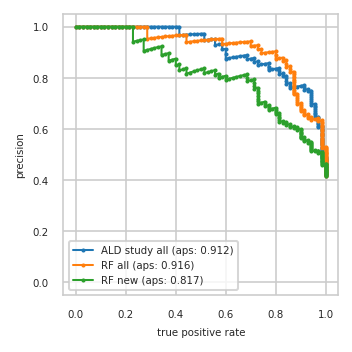

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


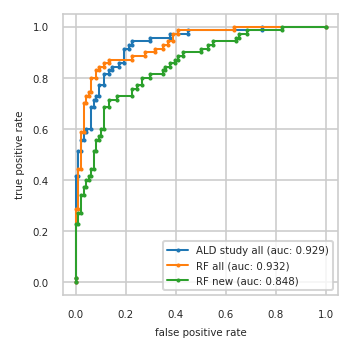

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}